In [ ]:
!pip install sktime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.signal import resample
import torch
import random
from sklearn.model_selection import train_test_split
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

In [ ]:
#random seed
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

In [ ]:
def cm_plot(y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()


In [ ]:
X_train_all = np.load("/kaggle/input/neymark-tsc/train_x.npy")
y_train_all = np.load("/kaggle/input/neymark-tsc/train_y.npy")
X_test = np.load("/kaggle/input/neymark-tsc/test_x.npy")

In [ ]:
print(f'ALL train data size = {len(X_train_all)}')
print(f'TEST data size = {len(X_test)}')

ALL train data size = 14667
TEST data size = 7225


### Let's Balance our Dataset using Oversampling and Augmentation!

Classes Counts = {0.0: 12102, 1.0: 378, 2.0: 993, 3.0: 103, 4.0: 1091}
Number of classes = 5


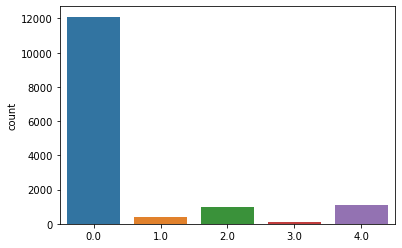

In [ ]:
classes_dict = dict(zip(*np.unique(y_train_all, return_counts = True)))
print(f'Classes Counts = {classes_dict}')

N_classes = len(classes_dict)
print(f'Number of classes = {N_classes}')

sns.countplot(x=y_train_all);

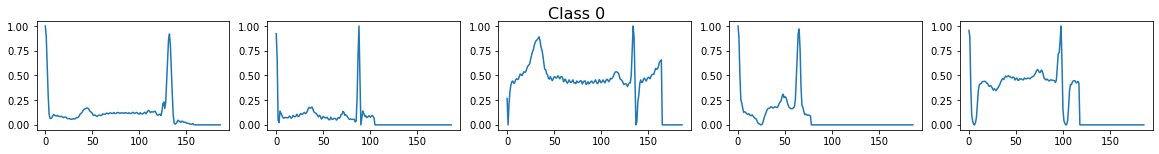

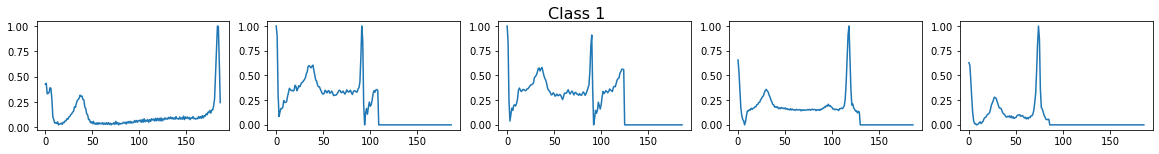

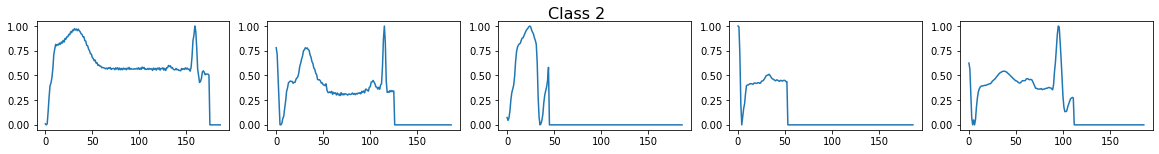

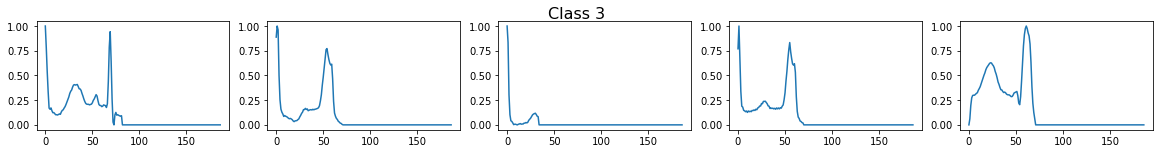

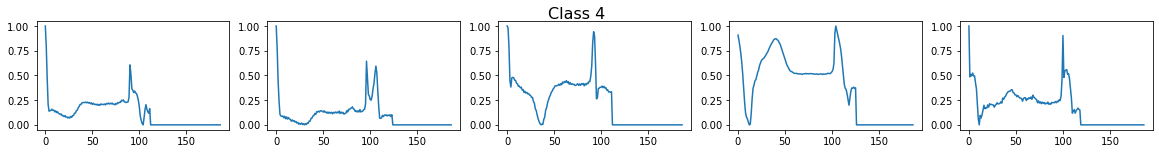

In [ ]:
#Let's visualize our Signals one by one
for _class in classes_dict:
    fig, ax = plt.subplots(1, 5, figsize=(20, 2))
    i = 0
    fig.suptitle('Class ' + str(int(_class)), fontsize=16)
    #display 5 pictures for every class
    for c in X_train_all[y_train_all == _class][:5]:
        sns.lineplot(x=np.arange(0, 187), y=c, ax=ax[i])
        i = i + 1
    plt.show();

In [ ]:
TIME = X_train_all.shape[1]

def stretch(x):
    l = int(TIME * (1 + (random.random() - 0.5)/3))
    y = resample(x, l)
    if l < TIME:
        y_ = np.zeros(shape=(TIME, ))
        y_[:l] = y
    else:
        y_ = y[:TIME]
    return y_

def amplify(x):
    alpha = random.random()-0.5 #from -0.5 to 0.5
    factor = -alpha*x + (1 + alpha)
    return x*factor

def addNoise(x, mean = 0.0, std = 1.0, factor = 0.01):
    noise = np.random.normal(mean, std, size = (TIME,))
    
    #normalize and ADD NOISE
    return x + noise * (x.max() - x.min()) * factor

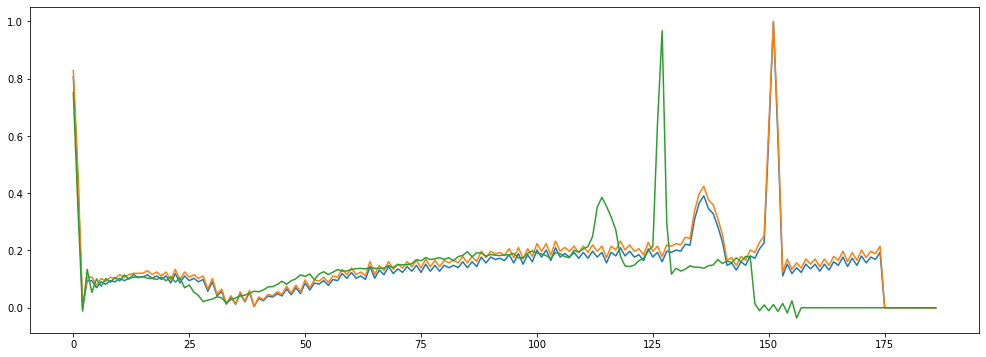

In [ ]:
idx = 10
plt.figure(figsize = (17,6))
plt.plot(X_train_all[idx, :])
plt.plot(amplify(X_train_all[idx, :]))
plt.plot(stretch(X_train_all[idx, :]))
plt.show()

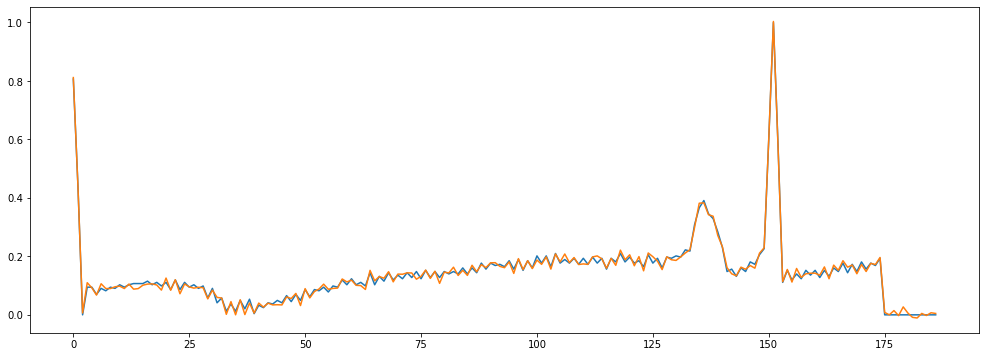

In [ ]:
#Let's visualize added Gaussian noise
plt.figure(figsize = (17,6))
plt.plot(X_train_all[idx, :])
plt.plot(addNoise(X_train_all[idx, :], factor = 0.01));

In [ ]:
def augment(x, p_value = 0.5, apply_noise = True):
    
    if random.random() > p_value:
        x = stretch(x)
    
    if random.random() > p_value:
        x = amplify(x)
    
    if apply_noise and random.random() > p_value:
        x = addNoise(x, factor = 0.01)
        
    return x

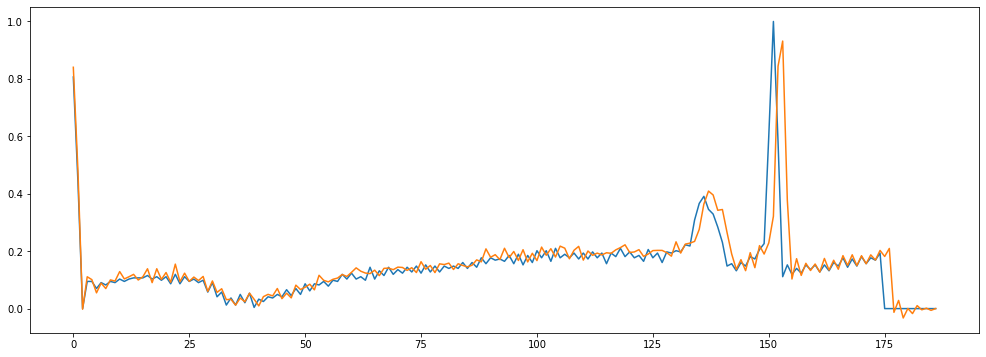

In [ ]:
#Let's visualize how augmentations are applied with Probability 100% each
plt.figure(figsize = (17,6))
plt.plot(X_train_all[idx, :])
plt.plot(augment(X_train_all[idx, :], apply_noise = True, p_value = 0.0));

In [ ]:
#Here we UnderSample or Oversample our train samples
#and applying Augmentation
#depends on the target Number of samples needed
def do_balance(X_train, y_train, classes_dict, target_num):
    
    result_X = None
    result_y = None
    
    for _class in classes_dict:
        
        indexes = np.argwhere(y_train == _class).flatten()
        actual_num = len(indexes)
        
        if actual_num > target_num:
            #need to do under sampling
            indexes = np.random.choice(indexes, target_num)
            
        elif actual_num < target_num:
            #do oversampling
            numRepeats = target_num // actual_num
            indexes = np.concatenate((np.repeat(indexes, numRepeats), np.random.choice(indexes, target_num - actual_num * numRepeats)))
        
        #apply augmentations
        X_per_class = np.apply_along_axis(augment, axis=1, arr=X_train[indexes])
        
        #do concatenate
        result_X = np.concatenate((result_X, X_per_class)) if result_X is not None else X_per_class
        result_y = np.concatenate((result_y, y_train[indexes])) if result_y is not None else y_train[indexes]
        
        print(f'Class = {int(_class)}, number of items = {actual_num}, after Augmentation = {len(X_per_class)}')
    
    return result_X, result_y

In [ ]:
#Do split to have Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=RANDOM_STATE, shuffle = True)

In [ ]:
print(f'Initial Train size = {len(y_train)}, Val size = {len(y_val)}')

Initial Train size = 11733, Val size = 2934


Class = 0, number of items = 9674, after Augmentation = 2000
Class = 1, number of items = 294, after Augmentation = 2000
Class = 2, number of items = 805, after Augmentation = 2000
Class = 3, number of items = 77, after Augmentation = 2000
Class = 4, number of items = 883, after Augmentation = 2000


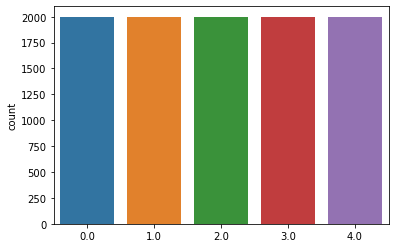

In [ ]:
from imblearn.over_sampling import SMOTE

USE_SMOTE = False

if not USE_SMOTE:
    target_balance = 2000 #6500; 12000
    X_train, y_train = do_balance(X_train, y_train, classes_dict, target_num = target_balance)
    X_train, y_train = shuffle(X_train, y_train, random_state = RANDOM_STATE)
else:
    sm = SMOTE(random_state=RANDOM_STATE)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(f'After SMOTE number of samples = {X_train.shape}')

sns.countplot(x=y_train);

## Model 1: Rocket as a baseline

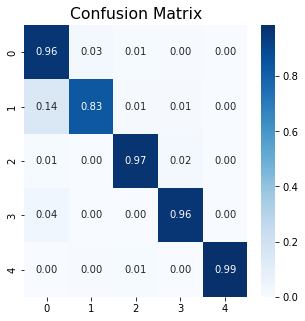

In [ ]:
rocket = RocketClassifier(num_kernels=5000, random_state = RANDOM_STATE)

rocket.fit(X_train, y_train)
y_pred = rocket.predict(X_val)

cm_plot(y_val, y_pred)

In [ ]:
print(f'Val accuracy = {accuracy_score(y_val, y_pred):.3f}')
print(f'Val F1 score = {f1_score(y_val, y_pred, average="macro"):.3f}')

Val accuracy = 0.958
Val F1 score = 0.854


In [ ]:
X_aug, y_aug = do_balance(X_train_all, y_train_all, classes_dict, target_num = 2000)

Class = 0, number of items = 12102, after Augmentation = 2000
Class = 1, number of items = 378, after Augmentation = 2000
Class = 2, number of items = 993, after Augmentation = 2000
Class = 3, number of items = 103, after Augmentation = 2000
Class = 4, number of items = 1091, after Augmentation = 2000


In [ ]:
#Train Rocket on Full Dataset
rocket_for_test = RocketClassifier(num_kernels=5000, random_state = RANDOM_STATE)

rocket_for_test.fit(X_aug, y_aug)

In [ ]:
y_test_pred = rocket_for_test.predict(X_test)

In [ ]:
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_test_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_test_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv.shape

### Best score for Rocket:

**F1 = 0.8407 on Test**

## Model 2: Simple CNN

In [ ]:
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, Normalization
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model_cnn = Sequential([
    
    Normalization(input_shape=(TIME,1)),
    
    Conv1D(64, 6, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2),
    
    Conv1D(64, 6, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2,strides=2),
    
    Conv1D(64,6,activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2,strides=2),
    
    Flatten(),

    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(len(classes_dict),activation='softmax')  
])

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 187, 1)            3         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 187, 64)           448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 187, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 93, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 64)            24640     
_________________________________________________________________
batch_normalization_6 (Batch (None, 93, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 46, 64)           

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=RANDOM_STATE, shuffle = True)

target_balance = 6500
X_train, y_train = do_balance(X_train, y_train, classes_dict, target_num = target_balance)
X_train, y_train = shuffle(X_train, y_train, random_state = RANDOM_STATE)

Class = 0, number of items = 9674, after Augmentation = 6500
Class = 1, number of items = 294, after Augmentation = 6500
Class = 2, number of items = 805, after Augmentation = 6500
Class = 3, number of items = 77, after Augmentation = 6500
Class = 4, number of items = 883, after Augmentation = 6500


In [ ]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

BATCH_SIZE = 128
LR = 1e-01

In [ ]:
model_cnn.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [ ]:
es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=12, restore_best_weights = True)

mc = ModelCheckpoint(filepath="best_cnn_17.hdf5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-05, verbose=1)

history_cnn = model_cnn.fit(x=X_train,
                            y=y_train_encoded,
                            epochs = 100,
                            batch_size = BATCH_SIZE,
                            validation_data = (X_val, y_val_encoded),
                            callbacks=[mc, es, reduce_lr],
                            use_multiprocessing=True,
                            workers=8)

Epoch 1/100
254/254 [==============================] - 18s 14ms/step - loss: 0.8114 - accuracy: 0.6904 - f1_m: 0.6713 - val_loss: 0.5703 - val_accuracy: 0.8200 - val_f1_m: 0.8189

Epoch 00001: val_accuracy improved from -inf to 0.82004, saving model to best_cnn_17.hdf5
Epoch 2/100
254/254 [==============================] - 3s 10ms/step - loss: 0.5006 - accuracy: 0.8238 - f1_m: 0.8216 - val_loss: 0.2474 - val_accuracy: 0.9387 - val_f1_m: 0.9387

Epoch 00002: val_accuracy improved from 0.82004 to 0.93865, saving model to best_cnn_17.hdf5
Epoch 3/100
254/254 [==============================] - 2s 9ms/step - loss: 0.3941 - accuracy: 0.8655 - f1_m: 0.8650 - val_loss: 0.8726 - val_accuracy: 0.7945 - val_f1_m: 0.7959

Epoch 00003: val_accuracy did not improve from 0.93865
Epoch 4/100
254/254 [==============================] - 2s 9ms/step - loss: 0.3436 - accuracy: 0.8861 - f1_m: 0.8866 - val_loss: 0.6251 - val_accuracy: 0.7931 - val_f1_m: 0.7933

Epoch 00004: val_accuracy did not improve from 

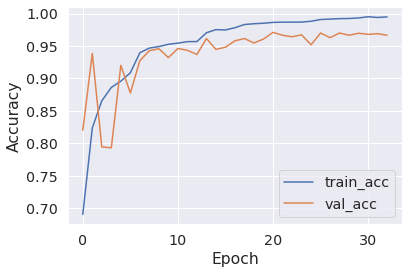

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.legend(["train_acc","val_acc"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

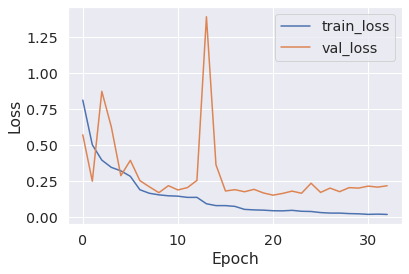

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.legend(["train_loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
# load the saved model
saved_cnn = load_model('best_cnn_17.hdf5', custom_objects = {'f1_m': f1_m})

In [ ]:
y_test_pred = np.argmax(saved_cnn.predict(X_test), axis=1)

In [ ]:
y_test_csv = pd.DataFrame(list(range(len(y_test_pred))), columns=["Id"])
y_test_csv["Answer"] = np.array(y_test_pred).astype(int).astype(str)
y_test_csv.to_csv("testing_submission_V17.csv", index=False)
y_test_csv;

### Best score for CNN:

**F1 score = 0.895 on Test**

## Model 3: Transformer using Pytorch

In [ ]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
import copy
import math
from tqdm import tqdm, tqdm_notebook
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
DEVICE = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!  Training on GPU ...


In [ ]:
class ECG_Dataset(Dataset):
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx:int): 
        if self.Y is not None:
            return self.X[idx], self.Y[idx]
        else:
            return self.X[idx]

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


#### ATTENTION
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.0):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = int(d_model // h)
        self.h = int(h)
        self.linears = clones(nn.Linear(d_model, d_model, dtype=torch.float64), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1) # Same mask applied to all h heads.
            
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(-1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears[:3], [query, key, value])
        ]
        
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = (x.transpose(1, 2).contiguous().view( -1, self.h * self.d_k))
        
        del query
        del key
        del value
        out = self.linears[-1](x)
        return out

## BLOCKING
class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features).to(DEVICE))
        self.b_2 = nn.Parameter(torch.zeros(features).to(DEVICE))
        self.eps = eps
    
    def forward(self, x):
        #print(f'Layer Norm input type = {x.dtype}')
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        #print(f'Layer Norm result type = {result.dtype}')

class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm."
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderBlock(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        x = self.sublayer[1](x, self.feed_forward)
        return x

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask=None):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class FeedForward(nn.Module):
    "Construct a FeedForward network with one hidden layer"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff, dtype=torch.float64)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(d_ff, d_model, dtype=torch.float64)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Transformer(nn.Module):
    "Transformer Model"
    def __init__(self, input_size, num_classes, num_heads=8, N=6, d_ff=256, dropout=0.0):
        super().__init__()
        c = copy.deepcopy
        attn = MultiHeadedAttention(num_heads, input_size)
        ff = FeedForward(input_size, d_ff, dropout)
        self.encoder = Encoder(EncoderBlock(input_size, c(attn), c(ff), dropout), N)
        self.fc = nn.Linear(input_size, num_classes, dtype=torch.float64)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

class EarlyStopping:
    def __init__(self, patience, verbose = 0, mode = 'mim'):
        self.patience = patience
        self.best_metric = float('inf') if mode == 'min' else 0.0
        self.best_epoch = -1
        self.early_stop = False
        self.verbose = verbose
        self.mode = mode

    def __call__(self, val_metric, epoch_index):
        if self.mode == 'max' and val_metric >= self.best_metric or self.mode == 'min' and val_metric <= self.best_metric:
            self.early_stop = False
            self.best_metric = val_metric
            self.best_epoch = epoch_index
        else:
            self.early_stop = (epoch_index - self.best_epoch) >= self.patience
            if self.verbose:
                print(f'EarlyStopping: current epoch {epoch_index + 1} no improvement for metric, best metric = {self.best_metric:0.4f} in epoch = {self.best_epoch + 1}')

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, epoch_index):
    
    model.train(True) #just in case - decided to switch model to train mode
    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    batches_total = len(train_loader) #returns number of batches
    y_preds = np.array([])
    y_true = np.array([])
    
    #displaying pretty progress bar for each epoch
    #with tqdm(desc=f"train epoch {epoch_index}:", leave=False, total=batches_total) as pbar_train:
    
    for inputs, labels in train_loader:

            inputs = inputs.to(DEVICE)
            labels = labels.type(torch.LongTensor).to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
            y_preds = np.concatenate((y_preds, preds.cpu().numpy()))
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            
            #pbar_train.update(1)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_m(y_true, y_preds)
    return train_loss, train_acc, train_f1

def eval_epoch(model, val_loader, criterion, epoch_index):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    y_preds = np.array([])
    y_true = np.array([])

    #displaying pretty progress bar for each epoch
    #with tqdm(desc=f"eval epoch {epoch_index}:", leave=False, total=len(val_loader)) as pbar_val:
            
    for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.type(torch.LongTensor).to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
            y_preds = np.concatenate((y_preds, preds.cpu().numpy()))
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            #pbar_val.update(1)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    val_f1 = f1_m(y_true, y_preds)
    return val_loss, val_acc, val_f1

In [ ]:
def train(X_train, Y_train, X_val, Y_val, model, epochs, batch_size, \
          criterion, opt, scheduler = None, early_stopping: EarlyStopping = None):
    
    train_loader = DataLoader(ECG_Dataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(ECG_Dataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f}, val_acc {v_acc:0.4f}, \
    train_f1 {train_f1:0.4f}, val_f1 {val_f1:0.4f} \
    best_val_f1 = {best_val_f1:0.4f}"

    # adding storage for best weights, will be finally used 
    # when training for all epochs is finished
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt, epoch)
            
            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion, epoch)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))
            
            #remember model weights if current accuracy is better than "best_acc"
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_wts = copy.deepcopy(model.state_dict())

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, \
                                           train_f1 = train_f1, v_acc=val_acc, \
                                           val_f1 = val_f1, best_val_f1 = best_f1))
            
             # if scheduler is defined, do LR step after every epoch
            if scheduler is not None:
                scheduler.step(val_loss)
            
            if early_stopping is not None:
                early_stopping(val_f1, epoch)
                if early_stopping.early_stop:
                    print(f'Early stopping, epoch = {epoch + 1}, best VAL F1 = {best_f1:0.4f}')
                    break
            
    # finally - let's load the best model weights
    model.load_state_dict(best_model_wts)        
            
    return model, history

def predict(model, test_loader):
    
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def init_parameters(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [ ]:
def do_padding(X_orig, new_length: int):
    X_result = []
    for sample in X_orig:
        if len(sample) < new_length:
            pad_size = new_length - len(sample)
            sample = np.concatenate((sample, np.array([0] * pad_size)))
        X_result.append(sample)
    return np.stack(X_result)

After SMOTE: number of X_train shape = (48370, 187), y_train shape = (48370,)


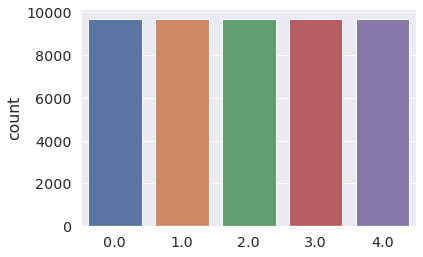

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=RANDOM_STATE, shuffle = True)

#Transformer works better with SMOTE and 9674 samples!
#Let's use SMOTE to Balance Dataset here

sm = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f'After SMOTE: number of X_train shape = {X_train.shape}, y_train shape = {y_train.shape}')

sns.countplot(x=y_train);

In [ ]:
#We need input size % number of heads == 0
#That's why I've decided to use Padding to pad sample size up to 190
INPUT_SIZE = 190

X_train = do_padding(X_train, new_length = INPUT_SIZE)
X_val = do_padding(X_val, new_length = INPUT_SIZE)

X_train.shape, X_val.shape

((48370, 190), (2934, 190))

In [ ]:
BATCH_SIZE = 128
DROPOUT = 0.3
LR = 5e-03
N_EPOCHS = 100
HUM_HEADS = 5
NUM_ENCODERS = 5 #were 6 before
DIM_FF = 128

model_t = Transformer(INPUT_SIZE, N_classes, HUM_HEADS, NUM_ENCODERS, d_ff = DIM_FF, dropout = DROPOUT)
init_parameters(model_t)

model_t = model_t.to(DEVICE)

optimizer = Adam(model_t.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, threshold=1e-05, verbose = 1)
early_stopping = EarlyStopping(patience = 10, verbose = 1, mode = 'max')

In [ ]:
print(model_t)

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=190, out_features=190, bias=True)
            (1): Linear(in_features=190, out_features=190, bias=True)
            (2): Linear(in_features=190, out_features=190, bias=True)
            (3): Linear(in_features=190, out_features=190, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): FeedForward(
          (fc1): Linear(in_features=190, out_features=128, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=128, out_features=190, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.3, inplace=False)
          )
          (1): SublayerConnection(
            (norm): Laye

In [ ]:
model_t, history = train(X_train, y_train, X_val, y_val, model_t, N_EPOCHS, BATCH_SIZE,\
                         criterion, optimizer, scheduler, early_stopping)

epoch:   1%|          | 1/100 [00:09<14:57,  9.06s/it]


Epoch 001 train_loss: 0.3293     val_loss 0.4015 train_acc 0.8862, val_acc 0.8654,     train_f1 0.9447, val_f1 0.7089     best_val_f1 = 0.7089


epoch:   2%|▏         | 2/100 [00:18<15:03,  9.22s/it]


Epoch 002 train_loss: 0.1544     val_loss 0.2389 train_acc 0.9464, val_acc 0.9257,     train_f1 0.9733, val_f1 0.8131     best_val_f1 = 0.8131


epoch:   3%|▎         | 3/100 [00:27<14:29,  8.96s/it]


Epoch 003 train_loss: 0.1199     val_loss 0.3116 train_acc 0.9592, val_acc 0.9063,     train_f1 0.9799, val_f1 0.7738     best_val_f1 = 0.8131
EarlyStopping: current epoch 3 no improvement for metric, best metric = 0.8131 in epoch = 2


epoch:   4%|▍         | 4/100 [00:35<14:06,  8.82s/it]


Epoch 004 train_loss: 0.1026     val_loss 0.3631 train_acc 0.9648, val_acc 0.8978,     train_f1 0.9821, val_f1 0.7660     best_val_f1 = 0.8131
EarlyStopping: current epoch 4 no improvement for metric, best metric = 0.8131 in epoch = 2


epoch:   5%|▌         | 5/100 [00:44<14:10,  8.95s/it]


Epoch 005 train_loss: 0.0910     val_loss 0.2351 train_acc 0.9696, val_acc 0.9318,     train_f1 0.9844, val_f1 0.8332     best_val_f1 = 0.8332


epoch:   6%|▌         | 6/100 [00:53<13:54,  8.87s/it]


Epoch 006 train_loss: 0.0814     val_loss 0.2777 train_acc 0.9731, val_acc 0.9192,     train_f1 0.9864, val_f1 0.8011     best_val_f1 = 0.8332
EarlyStopping: current epoch 6 no improvement for metric, best metric = 0.8332 in epoch = 5


epoch:   7%|▋         | 7/100 [01:02<13:55,  8.99s/it]


Epoch 007 train_loss: 0.0680     val_loss 0.2367 train_acc 0.9771, val_acc 0.9410,     train_f1 0.9881, val_f1 0.8539     best_val_f1 = 0.8539


epoch:   8%|▊         | 8/100 [01:11<13:39,  8.91s/it]


Epoch 008 train_loss: 0.0675     val_loss 0.2280 train_acc 0.9776, val_acc 0.9475,     train_f1 0.9880, val_f1 0.8627     best_val_f1 = 0.8627


epoch:   9%|▉         | 9/100 [01:20<13:36,  8.97s/it]


Epoch 009 train_loss: 0.0667     val_loss 0.2893 train_acc 0.9773, val_acc 0.9199,     train_f1 0.9881, val_f1 0.8118     best_val_f1 = 0.8627
EarlyStopping: current epoch 9 no improvement for metric, best metric = 0.8627 in epoch = 8


epoch:  10%|█         | 10/100 [01:29<13:19,  8.88s/it]


Epoch 010 train_loss: 0.0659     val_loss 0.2413 train_acc 0.9780, val_acc 0.9506,     train_f1 0.9888, val_f1 0.8697     best_val_f1 = 0.8697


epoch:  11%|█         | 11/100 [01:38<13:08,  8.86s/it]


Epoch 011 train_loss: 0.0632     val_loss 0.2872 train_acc 0.9789, val_acc 0.9189,     train_f1 0.9888, val_f1 0.8126     best_val_f1 = 0.8697
EarlyStopping: current epoch 11 no improvement for metric, best metric = 0.8697 in epoch = 10


epoch:  12%|█▏        | 12/100 [01:47<13:13,  9.02s/it]


Epoch 012 train_loss: 0.0525     val_loss 0.2524 train_acc 0.9818, val_acc 0.9458,     train_f1 0.9903, val_f1 0.8638     best_val_f1 = 0.8697
EarlyStopping: current epoch 12 no improvement for metric, best metric = 0.8697 in epoch = 10


epoch:  13%|█▎        | 13/100 [01:56<12:56,  8.92s/it]


Epoch 013 train_loss: 0.0495     val_loss 0.2558 train_acc 0.9834, val_acc 0.9482,     train_f1 0.9913, val_f1 0.8683     best_val_f1 = 0.8697
EarlyStopping: current epoch 13 no improvement for metric, best metric = 0.8697 in epoch = 10


epoch:  14%|█▍        | 14/100 [02:04<12:40,  8.84s/it]


Epoch 014 train_loss: 0.0553     val_loss 0.2576 train_acc 0.9811, val_acc 0.9441,     train_f1 0.9900, val_f1 0.8566     best_val_f1 = 0.8697
Epoch 00014: reducing learning rate of group 0 to 2.5000e-03.
EarlyStopping: current epoch 14 no improvement for metric, best metric = 0.8697 in epoch = 10


epoch:  15%|█▌        | 15/100 [02:13<12:28,  8.80s/it]


Epoch 015 train_loss: 0.0340     val_loss 0.2558 train_acc 0.9888, val_acc 0.9499,     train_f1 0.9938, val_f1 0.8656     best_val_f1 = 0.8697
EarlyStopping: current epoch 15 no improvement for metric, best metric = 0.8697 in epoch = 10


epoch:  16%|█▌        | 16/100 [02:22<12:30,  8.93s/it]


Epoch 016 train_loss: 0.0242     val_loss 0.2850 train_acc 0.9924, val_acc 0.9513,     train_f1 0.9959, val_f1 0.8718     best_val_f1 = 0.8718


epoch:  17%|█▋        | 17/100 [02:31<12:19,  8.91s/it]


Epoch 017 train_loss: 0.0216     val_loss 0.2811 train_acc 0.9931, val_acc 0.9574,     train_f1 0.9963, val_f1 0.8811     best_val_f1 = 0.8811


epoch:  18%|█▊        | 18/100 [02:40<12:06,  8.86s/it]


Epoch 018 train_loss: 0.0229     val_loss 0.2554 train_acc 0.9923, val_acc 0.9543,     train_f1 0.9956, val_f1 0.8837     best_val_f1 = 0.8837


epoch:  19%|█▉        | 19/100 [02:49<12:07,  8.98s/it]


Epoch 019 train_loss: 0.0187     val_loss 0.2831 train_acc 0.9942, val_acc 0.9571,     train_f1 0.9968, val_f1 0.8841     best_val_f1 = 0.8841


epoch:  20%|██        | 20/100 [02:58<11:48,  8.86s/it]


Epoch 020 train_loss: 0.0194     val_loss 0.3593 train_acc 0.9935, val_acc 0.9458,     train_f1 0.9964, val_f1 0.8605     best_val_f1 = 0.8841
Epoch 00020: reducing learning rate of group 0 to 1.2500e-03.
EarlyStopping: current epoch 20 no improvement for metric, best metric = 0.8841 in epoch = 19


epoch:  21%|██        | 21/100 [03:07<11:39,  8.86s/it]


Epoch 021 train_loss: 0.0128     val_loss 0.3279 train_acc 0.9959, val_acc 0.9554,     train_f1 0.9977, val_f1 0.8858     best_val_f1 = 0.8858


epoch:  22%|██▏       | 22/100 [03:16<11:32,  8.87s/it]


Epoch 022 train_loss: 0.0093     val_loss 0.3522 train_acc 0.9971, val_acc 0.9594,     train_f1 0.9983, val_f1 0.8930     best_val_f1 = 0.8930


epoch:  23%|██▎       | 23/100 [03:25<11:30,  8.97s/it]


Epoch 023 train_loss: 0.0083     val_loss 0.3519 train_acc 0.9974, val_acc 0.9584,     train_f1 0.9984, val_f1 0.8884     best_val_f1 = 0.8930
EarlyStopping: current epoch 23 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  24%|██▍       | 24/100 [03:33<11:17,  8.91s/it]


Epoch 024 train_loss: 0.0075     val_loss 0.3455 train_acc 0.9973, val_acc 0.9567,     train_f1 0.9984, val_f1 0.8860     best_val_f1 = 0.8930
EarlyStopping: current epoch 24 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  25%|██▌       | 25/100 [03:42<11:00,  8.81s/it]


Epoch 025 train_loss: 0.0098     val_loss 0.3593 train_acc 0.9969, val_acc 0.9543,     train_f1 0.9983, val_f1 0.8814     best_val_f1 = 0.8930
EarlyStopping: current epoch 25 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  26%|██▌       | 26/100 [03:51<11:01,  8.94s/it]


Epoch 026 train_loss: 0.0086     val_loss 0.3664 train_acc 0.9974, val_acc 0.9547,     train_f1 0.9984, val_f1 0.8818     best_val_f1 = 0.8930
Epoch 00026: reducing learning rate of group 0 to 6.2500e-04.
EarlyStopping: current epoch 26 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  27%|██▋       | 27/100 [04:00<10:47,  8.87s/it]


Epoch 027 train_loss: 0.0055     val_loss 0.3809 train_acc 0.9984, val_acc 0.9554,     train_f1 0.9991, val_f1 0.8842     best_val_f1 = 0.8930
EarlyStopping: current epoch 27 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  28%|██▊       | 28/100 [04:09<10:37,  8.85s/it]


Epoch 028 train_loss: 0.0034     val_loss 0.3979 train_acc 0.9990, val_acc 0.9540,     train_f1 0.9994, val_f1 0.8771     best_val_f1 = 0.8930
EarlyStopping: current epoch 28 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  29%|██▉       | 29/100 [04:18<10:26,  8.82s/it]


Epoch 029 train_loss: 0.0032     val_loss 0.4145 train_acc 0.9991, val_acc 0.9571,     train_f1 0.9995, val_f1 0.8840     best_val_f1 = 0.8930
EarlyStopping: current epoch 29 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  30%|███       | 30/100 [04:27<10:25,  8.93s/it]


Epoch 030 train_loss: 0.0031     val_loss 0.4167 train_acc 0.9990, val_acc 0.9564,     train_f1 0.9994, val_f1 0.8847     best_val_f1 = 0.8930
EarlyStopping: current epoch 30 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  31%|███       | 31/100 [04:36<10:14,  8.90s/it]


Epoch 031 train_loss: 0.0031     val_loss 0.4326 train_acc 0.9990, val_acc 0.9581,     train_f1 0.9994, val_f1 0.8882     best_val_f1 = 0.8930
EarlyStopping: current epoch 31 no improvement for metric, best metric = 0.8930 in epoch = 22


epoch:  32%|███▏      | 32/100 [04:44<10:05,  8.90s/it]


Epoch 032 train_loss: 0.0027     val_loss 0.4329 train_acc 0.9992, val_acc 0.9571,     train_f1 0.9995, val_f1 0.8837     best_val_f1 = 0.8930
Epoch 00032: reducing learning rate of group 0 to 3.1250e-04.
EarlyStopping: current epoch 32 no improvement for metric, best metric = 0.8930 in epoch = 22
Early stopping, epoch = 32, best VAL F1 = 0.8930


In [ ]:
train_loss, train_acc, train_f1, val_loss, val_acc, val_f1 = zip(*history)

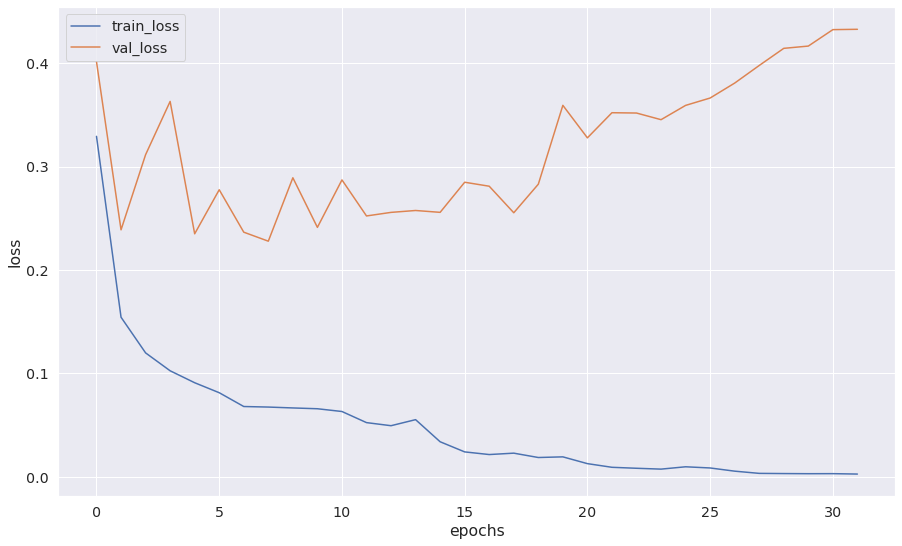

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

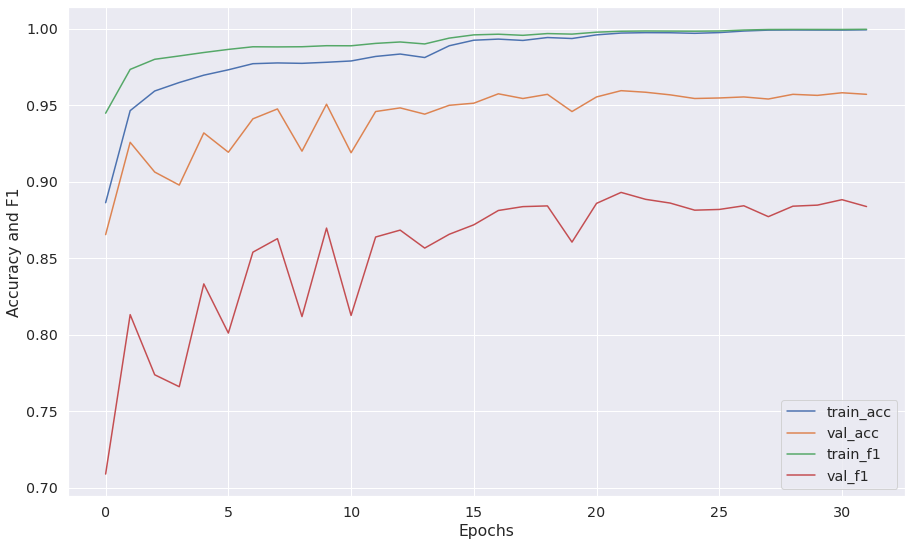

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(train_f1, label="train_f1")
plt.plot(val_f1, label="val_f1")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy and F1")
plt.show()

In [ ]:
X_test = do_padding(X_test, new_length = INPUT_SIZE)

test_loader = DataLoader(ECG_Dataset(X_test, None), batch_size=BATCH_SIZE, shuffle=False)

y_test_pred = predict(model_t, test_loader)
y_test_pred = y_test_pred.argmax(axis=1)

In [ ]:
y_test_csv = pd.DataFrame(list(range(len(y_test_pred))), columns=["Id"])
y_test_csv["Answer"] = np.array(y_test_pred).astype(int).astype(str)
y_test_csv.to_csv("testing_submission_V32.csv", index=False)
y_test_csv;

### Best score for Transformer:

**F1 score = 0.837 on Test**